In [1]:
from scipy.sparse import *
import numpy as np
import pickle
import random
from sklearn.decomposition import PCA
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from scipy.sparse import csc_matrix as smatrix
import scipy
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
# load vocabulary
with open('vocab_full.pkl', 'rb') as f:
    vocab = pickle.load(f)
list(vocab.items())[:10]

[('macedonia', 24804),
 ('loserr', 64100),
 ('retractable', 6990),
 ('samsonite', 23601),
 ("goat's", 21243),
 ('gaston', 70195),
 ('genting', 36694),
 ('biq', 40451),
 ('nannys', 75014),
 ('legacies', 33004)]

In [3]:
# construct num -> word dict
reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))

In [4]:
# file -> [[word_number_1_1, ..., word_number_1_K1], ..., [word_number_L_1, ..., word_number_L_KL]]
def file_to_word2numbers(filename):
    data = open(filename, 'rb')
    word2numbers_all = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        word2numbers = []
        for word in line:
            if word in vocab: word2numbers.append(vocab[word])
        if word2numbers:
            word2numbers_all.append(word2numbers)
    return word2numbers_all

In [5]:
# loading data -> numbers of words
pos_numbers = file_to_word2numbers('../data/train_pos_full.txt')
neg_numbers = file_to_word2numbers('../data/train_neg_full.txt')

1250000it [00:11, 106111.66it/s]
1250000it [00:13, 92733.75it/s]


In [6]:
# number of word occurences as embeddings (basic embeddings)
def numbers_to_dataset(numbers):
    arr = {}
    for i, tweet in tqdm(enumerate(numbers)):
        for number in tweet:
            p = (i, number)
            if p in arr: arr[p] += 1
            else: arr[p] = 1
                    
    keys = list(arr.keys())
    values = [arr[k] for k in keys]
    return coo_matrix((values, ([x for x, y in keys], [y for x, y in keys])), shape=(len(numbers), len(vocab)))

In [7]:
# applying it to numbers
pos_data = numbers_to_dataset(pos_numbers)
neg_data = numbers_to_dataset(neg_numbers)

1249957it [00:14, 88835.19it/s]
1249964it [00:14, 85116.51it/s]


In [8]:
# constructing X, y pair
def two_datasets_to_one(pos_data, neg_data):
    assert pos_data.shape[1] == neg_data.shape[1]
    X = scipy.sparse.vstack((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    assert X.shape[1] == pos_data.shape[1]
    return X, y

In [9]:
# applying to datasets (pos & neg)
X, y = two_datasets_to_one(pos_data, neg_data)

In [10]:
# making train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# training MLP on dataset

# use only part of training dataset
#idx = np.random.choice(range(X_train.shape[0]), 100000)
idx = list(range(X_train.shape[0]))
#clf = LogisticRegression(verbose=True, n_jobs = 8, solver = 'newton-cg', tol = 1e-4, C = 1e5, max_iter = 100000)
clf = MLPClassifier(verbose=True, solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(100, 50), random_state=1)
clf.fit(X_train[idx,:], y_train[idx])

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [12]:
# print resulting loss
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.869579326538
0.857211716351


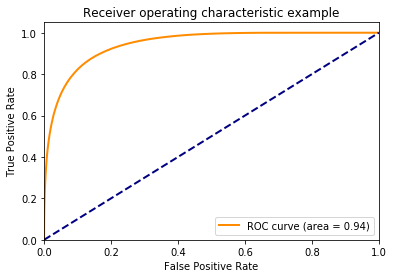

In [13]:
# plot ROC curve
fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [14]:
# open train and predict
def test_to_dataset(filename):
    data = open(filename, 'rb')
    idxes = []
    tweets_embeddings = []
    
    for line in tqdm(data):
        idx, line = line.strip().decode("utf-8").split(',', 1)
        idxes.append(idx)
        line = line.split(' ')
        tweet = []
        
        tweet_embeddings = np.zeros((len(vocab), ), dtype=np.float32)
        
        for word in line:
            if word in vocab:
                tweet_embeddings[vocab[word]] += 1
                
        tweets_embeddings.append(tweet_embeddings)
        
    #return tweets_embeddings
    tweets_embeddings = np.array(tweets_embeddings)
    assert len(idxes) == tweets_embeddings.shape[0]
    assert tweets_embeddings.shape[1] == len(vocab)
    return idxes, tweets_embeddings

In [15]:
# load training dataset
idx_test, X_test = test_to_dataset('../data/test_data.txt')

10000it [00:01, 8058.54it/s]


In [16]:
# predict outputs
y_predicted = np.array(2 * (clf.predict(X_test) - 0.5), dtype=np.int64)

In [17]:
# write outputs as (key, value) pairs
answers = sorted(zip(idx_test, y_predicted), key = lambda x: int(x[0]))

In [18]:
# write pairs to file
f = open('submission_count_nn_full.txt', 'w')
f.write("Id,Prediction\n")
for idx, ans in answers:
    f.write("%s,%s\n" % (idx, ans))
f.close()